# SMOTE: 
# Synthetic Minority Over-sampling Technique

## Алгоритм перебалансировки наблюдений по классам

Алгоритм предназначен для перебалансировки наблюдений с целью обеспечения баланса классов по целевой переменной (в задаче классификации). На выходе получается одинаковое число наблюдений по каждому классу. Количество наблюдений ничем не ограничивается, т.е. можно увеличивать число наблюдений и по максимальному классу. Таким образом перебалансировка увеличивает размер выборки.
Для уменьшения объема выборки используют метод Random Sampling.

## Описание алгоритма

Случайно выбирается наблюдение по классу (см. рисунок, стрелка), объём наблюдений которго нужно увеличить. Для него определяются k ближайших наблюдений того же класса. Случайно выбирается одно из них. Новое наблюдение генерируется умножением случайного значения от 0 до 1 на расстояние между каждым признаком этой пары наблюдений (о - новое наблюдение). В дальнейшем сгенерированное наблюдение не используется при поиске k ближайших при создании новых наблюдений.

Таким образом можно создавать наблюдения для малых классов балансируя выборку, а также добавлять наблюдения к наибольшему классу, увеличивая общее число наблюдений.

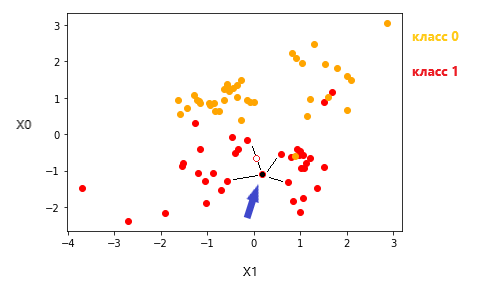

На новых данных метрики возрастут, но не нужно обольщаться потому как это синтетические наблюдения, не имеющие отношение к реальности. Зачем тогда это делать? - Я не знаю. Просто интересный алгоритм, легок в реализации. Попробовал, погравилось.

In [30]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

import numpy as np
import random
import pandas as pd

In [34]:
X, y = datasets.make_classification(n_classes=3, n_informative=5, n_samples=500)

In [35]:
class KNN:
    def __init__(self, k=3):
        self.k = k
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        labels = [self.find_labels(x_test) for x_test in X_test]
        return np.array(labels)
    
    def find_labels(self, x_test):
        distances = [self.distance(x_test, x_train) for x_train in self.X_train]   
        k_nearest = np.argsort(distances)[:self.k]
        y_labels = [self.y_train[i] for i in k_nearest]
            
        return self.most_common(y_labels)
        
    def most_common(self, y_labels):
        a = tuple(set(y_labels))
        count = [y_labels.count(i) for i in a]
        return a[np.argsort(count)[-1]]
    
    def score(self, y_predicted, y_train):
        return (y_predicted == y_train).sum() / len(y_train)

    def distance(self, x_test, x_train):
        return np.sqrt(np.abs(np.sum((x_test - x_train)**2)))
    
    def cv(self, X, y, cv=5):
        y = np.reshape(y, (len(y), 1))
        data = np.concatenate((X, y), axis=1)
        np.random.shuffle(data)
        
        data = pd.DataFrame(data)
        score = []
        
        for i in range(cv):
            lenght = int(len(y) / cv)
            
            end = i * lenght + lenght
            
            if i == cv - 1: 
                end = -1
            
            X_test = data.iloc[i * lenght: end, :-1]
            X_train = data.drop(index=X_test.index).iloc[:, :-1]
            
            y_test = data.iloc[i * lenght: end, -1]
            y_train = data.drop(index=X_test.index).iloc[:, -1]
            
            clf = KNN(k=self.k)
            clf.fit(np.array(X_train), np.array(y_train))
            s_ = clf.score(clf.predict(np.array(X_test)), np.array(y_test))
            score.append(s_)
        
        return np.array(score).mean()

In [39]:
class SMOTE:
    def __init__(self, k=4, observations=0):
        self.k = k
        self.ob = observations

    def fit(self, X, y):
        self.X_res = X
        self.y_res = y

    def distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2))

    def transform(self):
        self.classes = np.unique(self.y_res)
        # определение числа наблюдений по каждому классу
        self.counts = [np.where(self.y_res == i)[0].shape[0] for i in self.classes]

        if self.ob == 0:
            self.ob = max(self.counts)

        for ind, c in enumerate(self.classes):
            amount = self.counts[ind]
            
            if amount == self.ob:
                continue

            X_c = self.X_res[self.y_res == c]

            sample_len = self.ob - amount
            sample_ind = [random.randrange(0, amount - 1) for i in range(sample_len)]

            # продолжаем генерировать наблюдения до заданного количества
            while amount < self.ob:

                for ind in sample_ind:
                    x_parent = X_c[ind] # здесь будут исходные наблюдения
                    x_new = [] # здесь будут новые наблюдения

                    # находим k ближайших
                    distances = [self.distance(x_parent, x) for x in X_c]
                    k_nearest = np.argsort(distances)[1:self.k + 1]
                    
                    # выбираем случайное из них
                    x_random = X_c[random.choice(k_nearest)]
                    # умножаем расстояние между ними на случайное значение
                    delta = np.abs(x_parent - x_random) * random.random()

                    # полученное растояние конвертируем в признак
                    for x_p, x_r, dlt in zip(x_parent, x_random, delta):
                        x_new.append(min(x_p, x_r) + dlt)
                    
                    x_new = np.array([x_new])
                    
                    # добавляем сгенерированное наблюдение
                    self.X_res = np.concatenate((self.X_res, x_new), axis=0)
                    self.y_res = np.append(self.y_res, c)

                    amount += 1

        return self.X_res, self.y_res

In [40]:
%%time
# добавить наблюдений до
observations = 1000

# по ближайшим k соседям
res = SMOTE(k=3, observations=observations)
res.fit(X, y)

X_res, y_res = res.transform()

print("SMOTE, добавлено наблюдений по каждому классу до:", observations)
np.bincount(y_res)

SMOTE, добавлено наблюдений по каждому классу до: 1000
Wall time: 5.64 s


array([1000, 1000, 1000], dtype=int64)

In [42]:
clf = KNN(k=5)

print("original cv score:", str(clf.cv(X, y))[:5])

original cv score: 0.681


In [43]:
print("new data cv score:", str(clf.cv(X_res, y_res))[:5])

new data cv score: 0.996
